In [2]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.result import Counts, Result
from typing import Optional, List, Dict, Tuple, Union
from matplotlib import pyplot as plt
import itertools

In [3]:
import networkx as nx
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

C:\Users\Ittay\AppData\Local\Temp\ipykernel_7232\2228665778.py:3: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver


In [4]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.show()


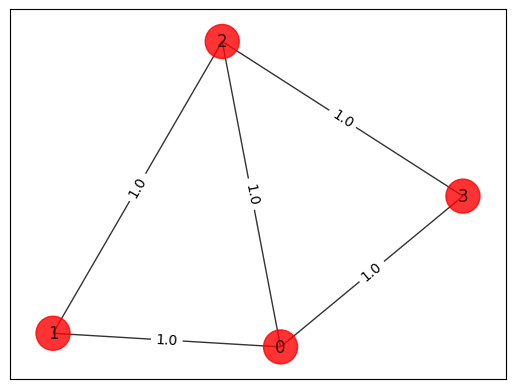

In [5]:
draw_graph(G, colors, pos)

In [6]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0


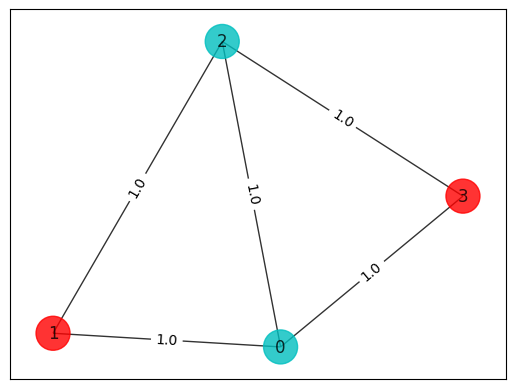


Best solution = [1, 0, 1, 0] cost = 4.0


In [7]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In [8]:
plt.show()

In [9]:
max_cut = Maxcut(w)  # W is the adj. mat. representation of G
qp = max_cut.to_quadratic_program()  # qp is the quantum program derived form G.
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [10]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [21]:
qubitOp.paulis[0][0]

Pauli('Z')

In [13]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


In [26]:
circuit = QuantumCircuit(4)
prep_MUB(circuit, 2, 0, [0,1])
state = Statevector.from_instruction(circuit)

In [27]:
new_state = state.evolve(prob_hamiltonian)

In [21]:
prob_hamiltonian = qubitOp.to_matrix_op()

In [28]:
new_state.inner(state) + offset

(-2+0j)

In [85]:
def compute_weight_matrix(graph):
    n = graph.number_of_nodes()
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = graph.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = 1
    return w

def create_quadratic_program(graph):
    w = compute_weight_matrix(graph)
    max_cut = Maxcut(w)
    qp = max_cut.to_quadratic_program()
    return qp

In [55]:
def create_MUB_state(A_mat, B_mat, num_qubits, qubits):
    circuit = QuantumCircuit(num_qubits)
    prep_MUB(circuit, A_mat, B_mat, qubits)
    state = Statevector.from_instruction(circuit)
    return state

def compute_cost_function(qubitOp, offset, state):
    prob_hamiltonian = qubitOp.to_matrix_op()
    new_state = state.evolve(prob_hamiltonian)
    cost = new_state.inner(state) + offset
    return cost

def get_exact_result(quadratic_program):
    exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = exact.solve(quadratic_program)
    return result

In [167]:
def calculate_energy_landscape(pair_list, qubit_op, offset):
    qubit_mapping_res = []
    for mapping in pair_list:
        MUBs_3qubits = []
        for mat_b in range(9):
            MUBs_3qubits.append([])
            for mat_a in range(8):
                circuit = QuantumCircuit(qubit_op.num_qubits)
                prep_MUB3(circuit, mat_a, mat_b, mapping)
                state = Statevector.from_instruction(circuit)
                mub_cost = compute_cost_function(qubit_op, offset, state)
                MUBs_3qubits[-1].append(np.abs(mub_cost))
        qubit_mapping_res.append(MUBs_3qubits)
    return qubit_mapping_res

def flatten_resutls(results):
    flatten_results = []
    for mapping_res in results:
        for MUB_basis in mapping_res:
            for MUB_element in MUB_basis:
                flatten_results.append(MUB_element)
    return flatten_results

# MUB preperation

In [120]:
# Adds Y-Hadamard gate on qubit q in circ
def yh(circ, q):
    circ.h(q)
    circ.s(q)

def prep_MUB(circ, A_mat, B_mat, qubits):
    # A_mat chooses the state in the basis (MUB)
    if A_mat == 1:
        circ.x(qubits[0])
    elif A_mat == 2:
        circ.x(qubits[1])
    elif A_mat == 3:
        circ.x(qubits[0])
        circ.x(qubits[1])
        
    # B_mat chooses the basis (MUB) itself
    if B_mat == 1:
        circ.h(qubits[0])
        circ.h(qubits[1])
    elif B_mat == 2:
        circ.h(qubits[0])
        yh(circ,qubits[1])
        circ.cz(qubits[0], qubits[1])
    elif B_mat == 3:
        yh(circ,qubits[0])
        yh(circ,qubits[1])
    elif B_mat == 4:
        yh(circ,qubits[0])
        circ.h(qubits[1])
        circ.cz(qubits[0], qubits[1])
        
def prep_MUB3(circ, A_mat, B_mat, qubits):
    # A_mat chooses the state in the basis (MUB)
    if A_mat == 1:
        circ.x(qubits[0])
    elif A_mat == 2:
        circ.x(qubits[1])
    elif A_mat == 3:
        circ.x(qubits[0])
        circ.x(qubits[1])
    elif A_mat == 4:
        circ.x(qubits[2])
    elif A_mat == 5:
        circ.x(qubits[0])
        circ.x(qubits[2])
    elif A_mat == 6:
        circ.x(qubits[1])
        circ.x(qubits[2])
    elif A_mat == 7:
        circ.x(qubits[0])
        circ.x(qubits[1])
        circ.x(qubits[2])
    
    # B_mat chooses the basis (MUB) itself
    if B_mat == 1:
        circ.h(qubits[0])
        circ.h(qubits[1])
        circ.h(qubits[2])
    elif B_mat == 2:
        yh(circ, qubits[0])
        yh(circ, qubits[1])
        yh(circ, qubits[2])
    elif B_mat == 3:
        yh(circ, qubits[0])
        circ.h(qubits[1])
        circ.h(qubits[2])
        circ.cz(qubits[1], qubits[2])
        circ.cz(qubits[0], qubits[1])
    elif B_mat == 4:
        circ.h(qubits[0])
        yh(circ, qubits[1])
        circ.h(qubits[2])
        circ.cz(qubits[1], qubits[2])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 5:
        circ.h(qubits[0])
        circ.h(qubits[1])
        yh(circ, qubits[2])
        circ.cz(qubits[0], qubits[1])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 6:
        yh(circ, qubits[0])
        yh(circ, qubits[1])
        circ.h(qubits[2])
        circ.cz(qubits[0], qubits[1])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 7:
        yh(circ, qubits[0])
        circ.h(qubits[1])
        yh(circ, qubits[2])
        circ.cz(qubits[1], qubits[2])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 8:
        circ.h(qubits[0])
        yh(circ, qubits[1])
        yh(circ, qubits[2])
        circ.cz(qubits[0], qubits[1])
        circ.cz(qubits[1], qubits[2])

In [11]:
def plot_MUB_energies(MUB_energies, exact_value, hf_value):
    x_indexes = list(range(len(MUB_energies)))

    fig = plt.figure(figsize=(8, 5))
    plt.plot(x_indexes, MUB_energies , lw=3, label="MUB energy")
    plt.plot(x_indexes, [exact_value] * len(x_indexes) , 'k', 
             lw=3, label="exact energy", linestyle="dashed")
    plt.plot(x_indexes, [hf_value] * len(x_indexes) ,color='#089FFF', 
             lw=3, label="hartree fock energy", linestyle="dashed")
    plt.xlabel("MUB index")
    plt.ylabel("Energy")
    plt.legend(frameon=False)
    plt.title("$H_2$ Energies")
    plt.show()

In [260]:
def get_indecies(list_of_energies, fisrt_index):
    indices = []
    indices += list(np.array(list_of_energies[fisrt_index::72]))
    indices += list(np.array(list_of_energies[fisrt_index+1::72]))
    indices += list(np.array(list_of_energies[fisrt_index+2::72]))
    indices += list(np.array(list_of_energies[fisrt_index+3::72]))
    indices += list(np.array(list_of_energies[fisrt_index+4::72]))
    indices += list(np.array(list_of_energies[fisrt_index+5::72]))
    indices += list(np.array(list_of_energies[fisrt_index+6::72]))
    indices += list(np.array(list_of_energies[fisrt_index+7::72]))
    return indices

In [267]:
def plot_MUB_energies2(MUB_energies, exact_value, title):
    x_indexes = np.array(list(range(len(MUB_energies))))
    MUB_energies = np.array(MUB_energies)
    indices_0 = get_indecies(x_indexes, 0)
    indices_1 = get_indecies(x_indexes, 8)
    indices_2 = get_indecies(x_indexes, 16)
    indices_3 = get_indecies(x_indexes, 24)
    indices_4 = get_indecies(x_indexes, 32)
    indices_5 = get_indecies(x_indexes, 40)
    indices_6 = get_indecies(x_indexes, 48)
    indices_7 = get_indecies(x_indexes, 56)
    indices_8 = get_indecies(x_indexes, 64)

    fig = plt.figure(figsize=(8, 5))
    plt.plot(x_indexes[indices_0], MUB_energies[indices_0] , 'o', lw=3, label="MUB energy, basis 0")
    plt.plot(x_indexes[indices_1], MUB_energies[indices_1] , 'o', lw=3, label="MUB energy, basis 1")
    plt.plot(x_indexes[indices_2], MUB_energies[indices_2] , 'o', lw=3, label="MUB energy, basis 2")
    plt.plot(x_indexes[indices_3], MUB_energies[indices_3] , 'o', lw=3, label="MUB energy, basis 3")
    plt.plot(x_indexes[indices_4], MUB_energies[indices_4] , 'o', lw=3, label="MUB energy, basis 4")
    plt.plot(x_indexes[indices_5], MUB_energies[indices_5] , 'o', lw=3, label="MUB energy, basis 5")
    plt.plot(x_indexes[indices_6], MUB_energies[indices_6] , 'o', lw=3, label="MUB energy, basis 6")
    plt.plot(x_indexes[indices_7], MUB_energies[indices_7] , 'o', lw=3, label="MUB energy, basis 7")
    plt.plot(x_indexes[indices_8], MUB_energies[indices_8] , 'o', lw=3, label="MUB energy, basis 8")
    plt.plot(x_indexes, [exact_value] * len(x_indexes) , 'k', 
             lw=3, label="Optimal result", linestyle="dashed")
    plt.xlabel("MUB index")
    plt.ylabel("Cost function result")
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

In [268]:
def plot_MUB_energies3(MUB_energies, exact_value, title):
    x_indexes = np.array(list(range(len(MUB_energies))))
    MUB_energies = np.array(MUB_energies)
    indices_0 = get_indecies(x_indexes, 0)
    indices_1 = get_indecies(x_indexes, 8)
    indices_2 = get_indecies(x_indexes, 16)
    indices_3 = get_indecies(x_indexes, 24)
    indices_4 = get_indecies(x_indexes, 32)
    indices_5 = get_indecies(x_indexes, 40)
    indices_6 = get_indecies(x_indexes, 48)
    indices_7 = get_indecies(x_indexes, 56)
    indices_8 = get_indecies(x_indexes, 64)

    fig = plt.figure(figsize=(8, 5))
    plt.plot(x_indexes[indices_0], MUB_energies[indices_0] , 'o', lw=3, label="MUB energy, basis 0")
    plt.plot(x_indexes[indices_1], MUB_energies[indices_1] , 'o', lw=3, label="MUB energy, basis 1")
    plt.plot(x_indexes[indices_2], MUB_energies[indices_2] , 'o', lw=3, label="MUB energy, basis 2")
    plt.plot(x_indexes[indices_3], MUB_energies[indices_3] , 'o', lw=3, label="MUB energy, basis 3")
    plt.plot(x_indexes[indices_4], MUB_energies[indices_4] , 'o', lw=3, label="MUB energy, basis 4")
    plt.plot(x_indexes[indices_5], MUB_energies[indices_5] , 'o', lw=3, label="MUB energy, basis 5")
    plt.plot(x_indexes[indices_6], MUB_energies[indices_6] , 'o', lw=3, label="MUB energy, basis 6")
    plt.plot(x_indexes[indices_7], MUB_energies[indices_7] , 'o', lw=3, label="MUB energy, basis 7")
    plt.plot(x_indexes[indices_8], MUB_energies[indices_8] , 'o', lw=3, label="MUB energy, basis 8")
    plt.plot(x_indexes, [exact_value] * len(x_indexes) , 'k', 
             lw=3, label="Optimal result", linestyle="dashed")
    plt.xlabel("MUB index")
    plt.ylabel("Cost function result")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()

# Calculate the energy for MUB states

In [100]:
rand_graph = nx.gnm_random_graph(3, 3)

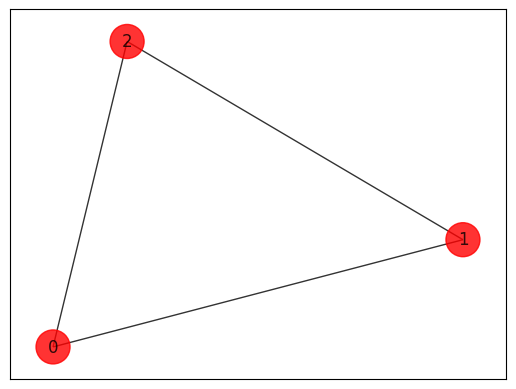

In [101]:
rand_colors = ["r" for node in rand_graph.nodes()]
rand_pos = nx.spring_layout(rand_graph)


draw_graph(rand_graph, rand_colors, rand_pos)

In [102]:
rand_qp = create_quadratic_program(rand_graph)

In [103]:
rand_qubitOp, rand_offset = rand_qp.to_ising()

In [104]:
rand_exact_res = get_exact_result(rand_qp)

In [105]:
print(rand_exact_res.prettyprint())

objective function value: 2.0
variable values: x_0=1.0, x_1=0.0, x_2=0.0
status: SUCCESS


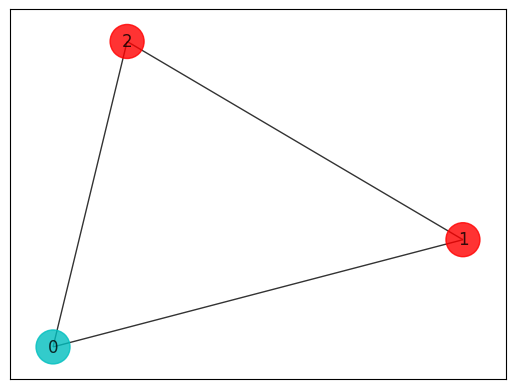

In [106]:
sol_rand_colors = ["r" if rand_exact_res.x[i] == 0 else "c" for i in range(len(rand_exact_res.x))]
draw_graph(rand_graph, sol_rand_colors, rand_pos)

In [113]:
pair_list = []
for elem in itertools.combinations(np.linspace(0,2,3, dtype=int), 3):
    pair_list.append(elem)

In [138]:
qubit_mapping_res_3qubits = calculate_energy_landscape(pair_list, rand_qubitOp, rand_offset)

In [139]:
qubit_mapping_res_3qubits_flatten = flatten_resutls(qubit_mapping_res_3qubits)

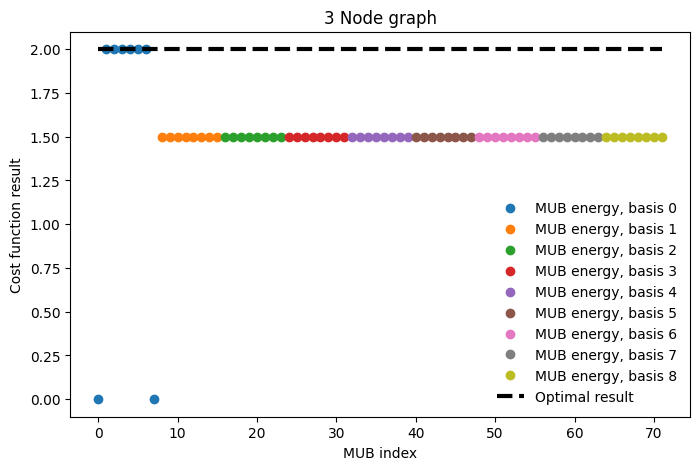

In [269]:
plot_MUB_energies2(qubit_mapping_res_3qubits_flatten, rand_exact_res.fval, "3 Node graph")

In [144]:
rand_graph_4 = nx.gnm_random_graph(4, 5)

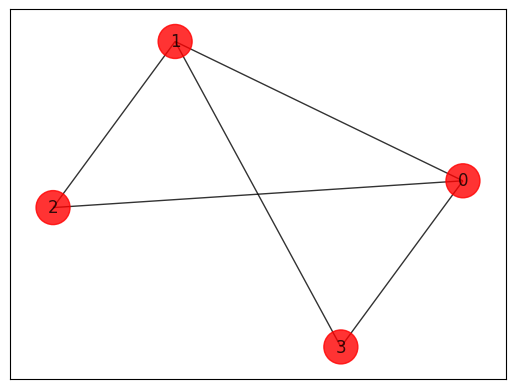

In [145]:
rand_colors_4 = ["r" for node in rand_graph.nodes()]
rand_pos_4 = nx.spring_layout(rand_graph)


draw_graph(rand_graph_4, rand_colors_4, rand_pos_4)

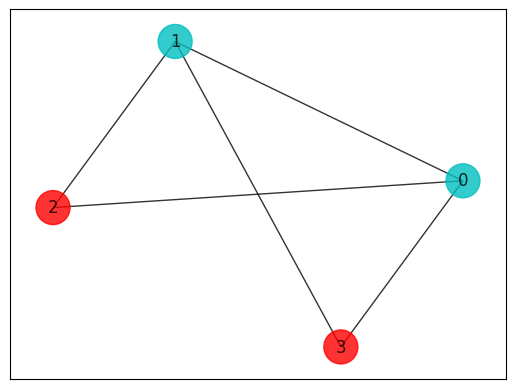

In [146]:
rand_qp_4 = create_quadratic_program(rand_graph_4)
rand_qubitOp_4, rand_offset_4 = rand_qp_4.to_ising()
rand_exact_res_4 = get_exact_result(rand_qp_4)
sol_rand_colors_4 = ["r" if rand_exact_res_4.x[i] == 0 else "c" for i in range(len(rand_exact_res_4.x))]
draw_graph(rand_graph_4, sol_rand_colors_4, rand_pos_4)

In [147]:
pair_list_4 = []
for elem in itertools.combinations(np.linspace(0,3,4, dtype=int), 3):
    pair_list_4.append(elem)

In [155]:
qubit_mapping_res_3qubits_4 = calculate_energy_landscape(pair_list_4, rand_qubitOp_4, rand_offset_4)

In [156]:
qubit_mapping_res_3qubits_flatten_4 = flatten_resutls(qubit_mapping_res_3qubits_4)

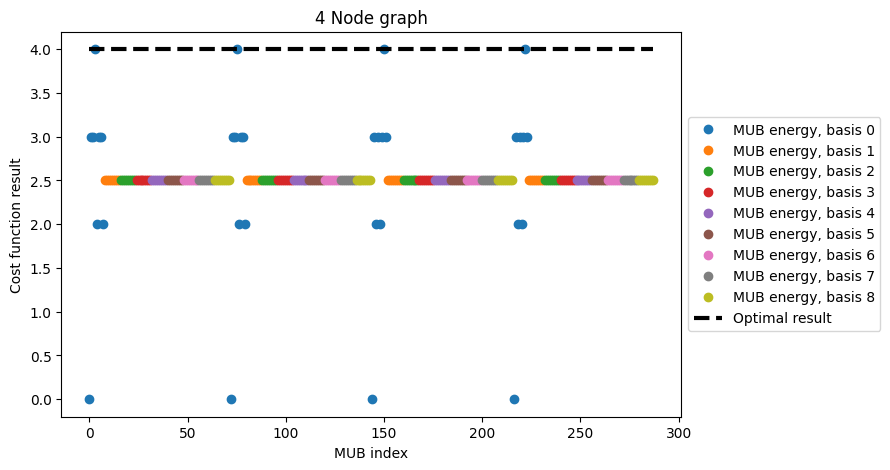

In [270]:
plot_MUB_energies3(qubit_mapping_res_3qubits_flatten_4, rand_exact_res_4.fval, "4 Node graph")

In [168]:
rand_graph_5 = nx.gnm_random_graph(5, 9)

In [171]:
def plot_graph1(rand_graph):
    rand_colors = ["r" for node in rand_graph.nodes()]
    rand_pos = nx.spring_layout(rand_graph)

    draw_graph(rand_graph, rand_colors, rand_pos)
    return rand_colors, rand_pos

def plot_graph2(rand_graph, rand_pos):
    rand_qp = create_quadratic_program(rand_graph)
    rand_qubitOp, rand_offset = rand_qp.to_ising()
    rand_exact_res = get_exact_result(rand_qp)
    sol_rand_colors = ["r" if rand_exact_res.x[i] == 0 else "c" for i in range(len(rand_exact_res.x))]
    draw_graph(rand_graph, sol_rand_colors, rand_pos)
    
    return rand_qp, rand_qubitOp, rand_offset, rand_exact_res, sol_rand_colors

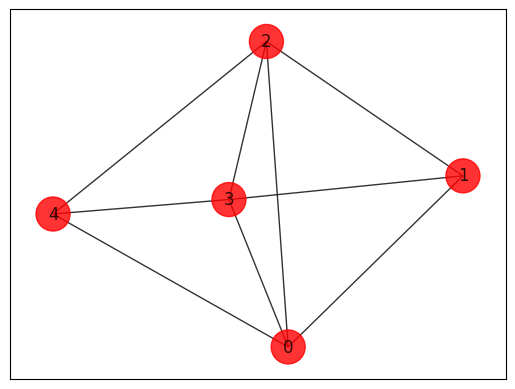

In [170]:
rand_colors_5, rand_pos_5 = plot_graph1(rand_graph_5)

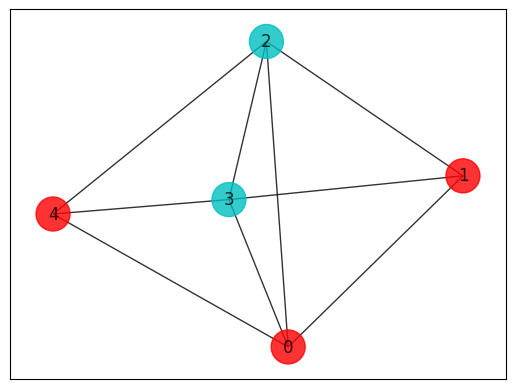

In [172]:
rand_qp_5, rand_qubitOp_5, rand_offset_5, rand_exact_res_5, sol_rand_colors_5 = plot_graph2(rand_graph_5, rand_pos_5)

In [174]:
pair_list_5 = []
for elem in itertools.combinations(np.linspace(0,4,5, dtype=int), 3):
    pair_list_5.append(elem)
qubit_mapping_res_3qubits_5 = calculate_energy_landscape(pair_list_5, rand_qubitOp_5, rand_offset_5)
qubit_mapping_res_3qubits_flatten_5 = flatten_resutls(qubit_mapping_res_3qubits_5)

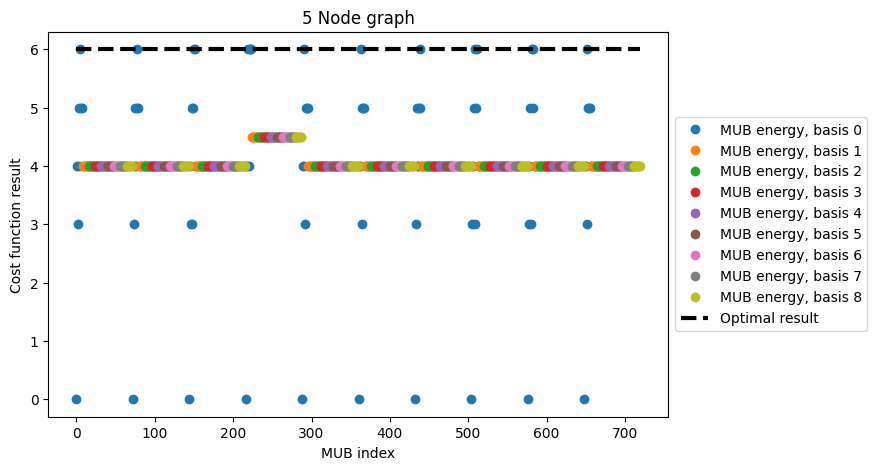

In [271]:
plot_MUB_energies3(qubit_mapping_res_3qubits_flatten_5, rand_exact_res_5.fval, "5 Node graph")

In [182]:
rand_graph_6 = nx.gnm_random_graph(6, 12)

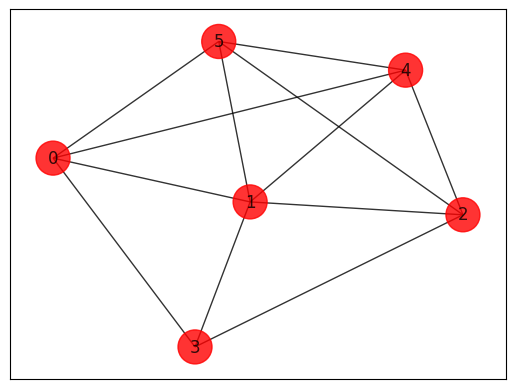

In [183]:
rand_colors_6, rand_pos_6 = plot_graph1(rand_graph_6)

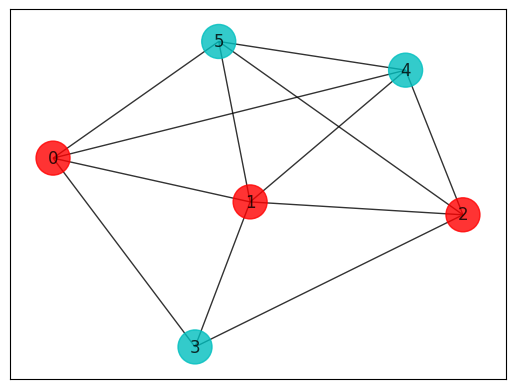

In [184]:
rand_qp_6, rand_qubitOp_6, rand_offset_6, rand_exact_res_6, sol_rand_colors_6 = plot_graph2(rand_graph_6, rand_pos_6)

In [185]:
pair_list_6 = []
for elem in itertools.combinations(np.linspace(0,5,6, dtype=int), 3):
    pair_list_6.append(elem)
qubit_mapping_res_3qubits_6 = calculate_energy_landscape(pair_list_6, rand_qubitOp_6, rand_offset_6)
qubit_mapping_res_3qubits_flatten_6 = flatten_resutls(qubit_mapping_res_3qubits_6)

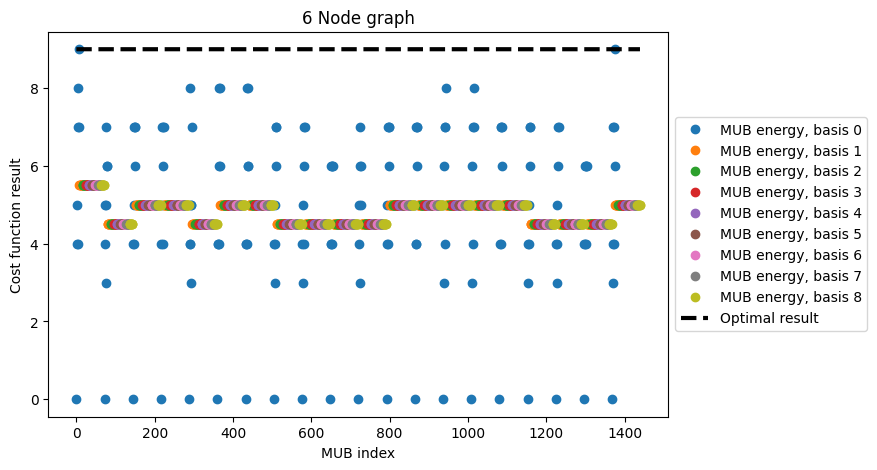

In [272]:
plot_MUB_energies3(qubit_mapping_res_3qubits_flatten_6, rand_exact_res_6.fval, "6 Node graph")

In [187]:
rand_graph_7 = nx.gnm_random_graph(7, 12)

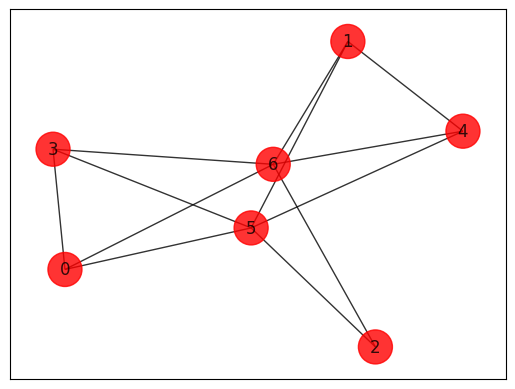

In [188]:
rand_colors_7, rand_pos_7 = plot_graph1(rand_graph_7)

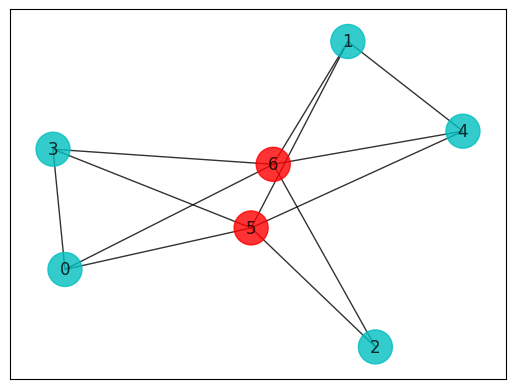

In [189]:
rand_qp_7, rand_qubitOp_7, rand_offset_7, rand_exact_res_7, sol_rand_colors_7 = plot_graph2(rand_graph_7, rand_pos_7)

In [190]:
pair_list_7 = []
for elem in itertools.combinations(np.linspace(0,6,7, dtype=int), 3):
    pair_list_7.append(elem)
qubit_mapping_res_3qubits_7 = calculate_energy_landscape(pair_list_7, rand_qubitOp_7, rand_offset_7)
qubit_mapping_res_3qubits_flatten_7 = flatten_resutls(qubit_mapping_res_3qubits_7)

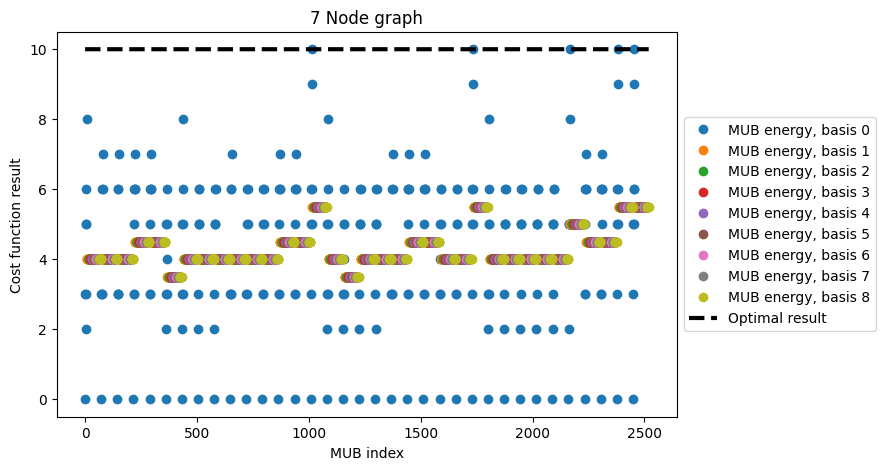

In [273]:
plot_MUB_energies3(qubit_mapping_res_3qubits_flatten_7, rand_exact_res_7.fval, "7 Node graph")

In [199]:
rand_graph_8 = nx.gnm_random_graph(8, 14)

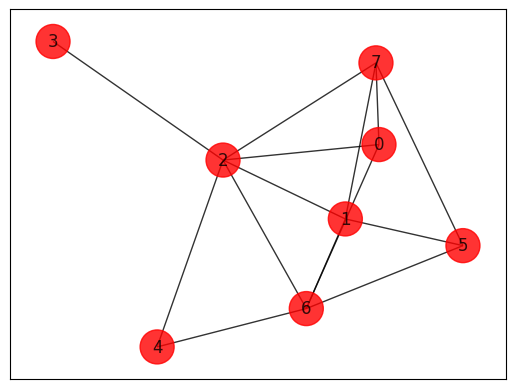

In [200]:
rand_colors_8, rand_pos_8 = plot_graph1(rand_graph_8)

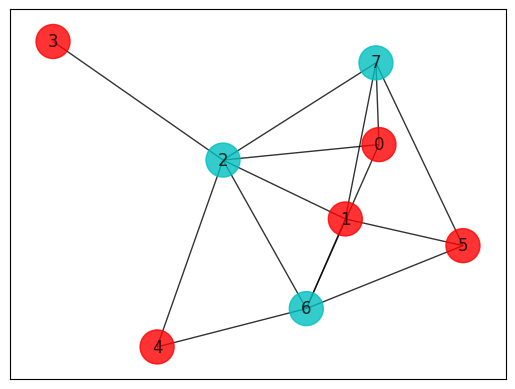

In [201]:
rand_qp_8, rand_qubitOp_8, rand_offset_8, rand_exact_res_8, sol_rand_colors_8 = plot_graph2(rand_graph_8, rand_pos_8)

In [202]:
pair_list_8 = []
for elem in itertools.combinations(np.linspace(0,7,8, dtype=int), 3):
    pair_list_8.append(elem)
qubit_mapping_res_3qubits_8 = calculate_energy_landscape(pair_list_8, rand_qubitOp_8, rand_offset_8)
qubit_mapping_res_3qubits_flatten_8 = flatten_resutls(qubit_mapping_res_3qubits_8)

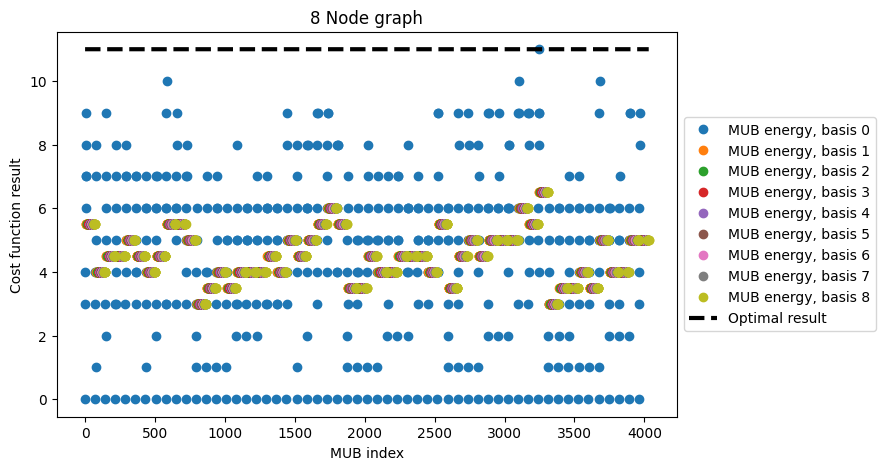

In [274]:
plot_MUB_energies3(qubit_mapping_res_3qubits_flatten_8, rand_exact_res_8.fval, "8 Node graph")

In [207]:
rand_graph_9 = nx.gnm_random_graph(9, 20)

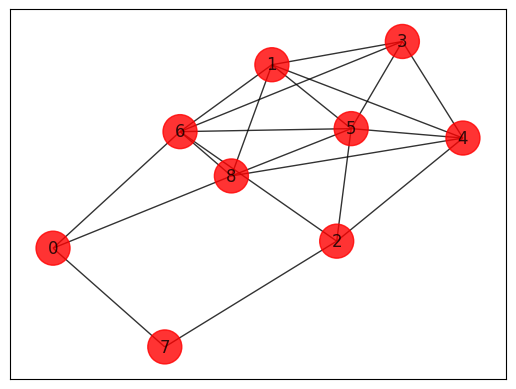

In [208]:
rand_colors_9, rand_pos_9 = plot_graph1(rand_graph_9)

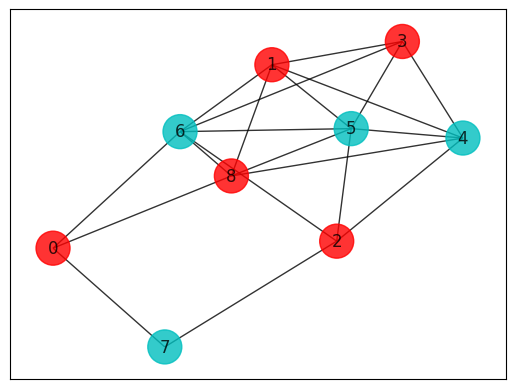

In [210]:
rand_qp_9, rand_qubitOp_9, rand_offset_9, rand_exact_res_9, sol_rand_colors_9 = plot_graph2(rand_graph_9, rand_pos_9)

In [211]:
pair_list_9 = []
for elem in itertools.combinations(np.linspace(0,8,9, dtype=int), 3):
    pair_list_9.append(elem)
qubit_mapping_res_3qubits_9 = calculate_energy_landscape(pair_list_9, rand_qubitOp_9, rand_offset_9)
qubit_mapping_res_3qubits_flatten_9 = flatten_resutls(qubit_mapping_res_3qubits_9)

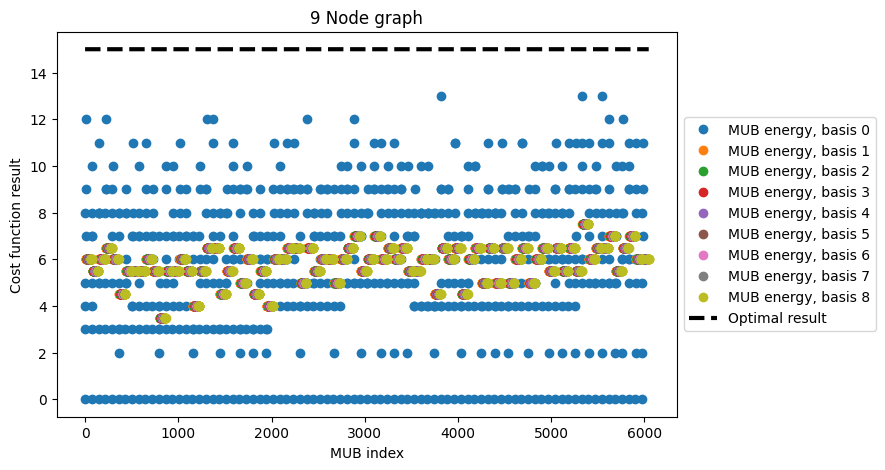

In [275]:
plot_MUB_energies3(qubit_mapping_res_3qubits_flatten_9, rand_exact_res_9.fval, "9 Node graph")

In [239]:
rand_graph_10 = nx.gnm_random_graph(10, 22)

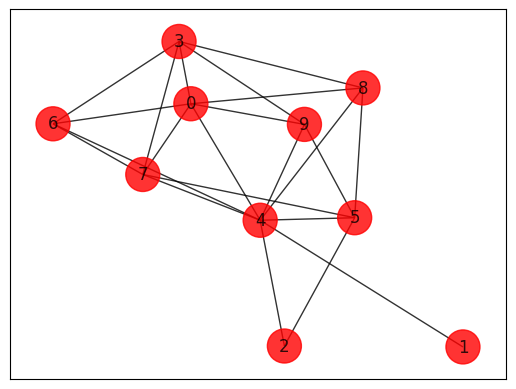

In [240]:
rand_colors_10, rand_pos_10 = plot_graph1(rand_graph_10)

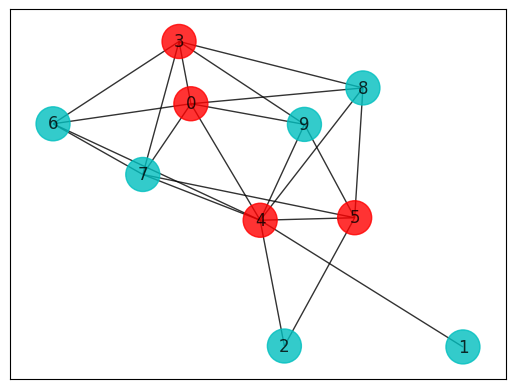

In [241]:
rand_qp_10, rand_qubitOp_10, rand_offset_10, rand_exact_res_10, sol_rand_colors_10 = plot_graph2(
    rand_graph_10, rand_pos_10)

In [242]:
pair_list_10 = []
for elem in itertools.combinations(np.linspace(0,9,10, dtype=int), 3):
    pair_list_10.append(elem)
qubit_mapping_res_3qubits_10 = calculate_energy_landscape(pair_list_10, rand_qubitOp_10, rand_offset_10)
qubit_mapping_res_3qubits_flatten_10 = flatten_resutls(qubit_mapping_res_3qubits_10)

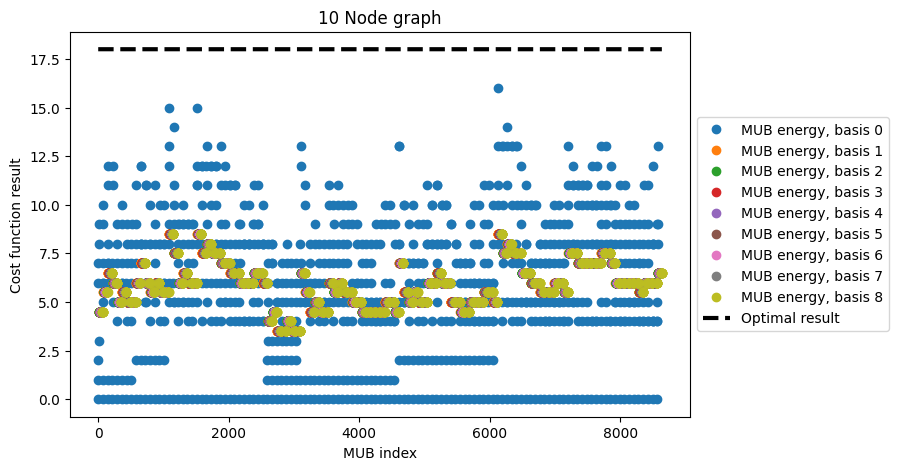

In [276]:
plot_MUB_energies3(qubit_mapping_res_3qubits_flatten_10, rand_exact_res_10.fval, "10 Node graph")